In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import os
import torch
import scanpy as sc 
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

embedding_dir = '/ix/djishnu/alw399/SLIDE_PLM/data/pjm_models/embeddings/15epochs'

/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [3]:
# # CLONAL EXPANSION
# name = 'jing_clonal_expansion'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
# y = pd.read_csv(y_path)['Y'].values
# sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_betaseqs_raw.csv', index_col=0)

# JING TUMOR
name = 'jing_tumor'
n_pcs = 16
model_name = f'pjm_15epochs_pca{n_pcs}'
y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/tumor_y2.csv'
slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/0.05_0.5_out'
y = pd.read_csv(y_path)['y'].values
sequences = pd.read_csv('/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/filtered_x2_cdr3_b.csv')

# # ANTIGEN SPECIFICITY
# name = 'alok_antigen_specificity'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/alok_data/alok_data12_MRfilt_noint_out/0.01_2_out'
# x_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_forSLIDE.csv'
# y_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_antigens.csv' 
# y = pd.read_csv(y_path)['Antigen'].values - 1
# sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_seqs.csv', index_col=0)['beta']

# # CONGA c2_gex_donor1
# name = 'conga_c2_gex_donor1'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/inputs/10x_200k_donor1_y.csv'
# slide_outs = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/outputs/10x_200k_donor1/0.01_0.5_out'
# barcodes = pd.read_csv(y_path).index
# y = pd.read_csv(y_path)['is_c2'].values
# adata = sc.read_h5ad('/ix3/djishnu/alw399/SLIDE_PLM/data/conga/toJishnu/10x_200k_donor1.h5ad')
# sequences = adata[barcodes, :].obs['cdr3b']

# # CONGA mait donor1
# name = 'conga_mait_donor1'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/inputs/10x_200k_donor1_mait_y.csv'
# slide_outs = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/outputs/10x_200k_donor1_mait/0.01_0.5_out'
# barcodes = pd.read_csv(y_path).index
# y = pd.read_csv(y_path)['is_mait'].values
# adata = sc.read_h5ad('/ix3/djishnu/alw399/SLIDE_PLM/data/conga/toJishnu/10x_200k_donor1.h5ad')
# sequences = adata[barcodes, :].obs['cdr3b']
# # sequences = adata[barcodes, :].obs['cdr3a']


In [4]:
from util import get_sigLFs

z1s = get_sigLFs(slide_outs)
z_matrix = pd.read_csv(os.path.join(slide_outs, 'z_matrix.csv'), index_col=0)
z_matrix = z_matrix[z1s]
z_matrix.shape

(3859, 3)

In [5]:
# Interactors did not contribute to signal
# z_matrix = pd.DataFrame(z_matrix['Z7'])
# z_matrix = pd.DataFrame(z_matrix['Z79'])

In [6]:
from util import remove_empty_tcrs

sequences, y, z_matrix = remove_empty_tcrs(sequences, y, z_matrix)
sequences.shape, y.shape, z_matrix.shape

((2627,), (2627,), (2627, 3))

### Get embeddings from pjm model

In [15]:
from pjm.pjm import from_pretrained, build_default_alphabet

alphabet = build_default_alphabet()

# Load encoder
embedder = from_pretrained(
    model_type="mmplm",
    alphabet=alphabet,
    checkpoint_path='/ix/djishnu/alw399/SLIDE_PLM/data/pjm_models/mmplm_15epochs_dim256_ckpt.pth',
)

In [16]:
tokenizer = alphabet.get_batch_converter()

batch_labels = sequences.astype(str)
seq_str_list = sequences.astype(str)
raw_batch = list(zip(batch_labels, seq_str_list))

labels, strs, tokens = tokenizer(raw_batch)

In [17]:
embeddings = embedder(tokens)
embeddings.shape

torch.Size([1109, 24, 256])

In [18]:
np.save(os.path.join(embedding_dir, f'{name}.npy'), embeddings.detach().numpy())

### Run interactions

In [6]:
embeddings = np.load(os.path.join(embedding_dir, f'{name}.npy'))
embeddings.shape

(2627, 27, 256)

In [7]:
embeddings = embeddings.mean(axis=1)
# embeddings = embeddings.mean(axis=2)
embeddings.shape

(2627, 256)

In [10]:
from sklearn.decomposition import PCA

model = PCA(n_components=n_pcs)
model.fit(embeddings)
tcr_embeddings = model.transform(embeddings)
tcr_embeddings.shape

(2627, 16)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
scatter = ax[0].scatter(tcr_embeddings[:, 0], tcr_embeddings[:, 1], c=y, cmap='cool', s=5)
legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
# ax[0].set_title('PJM TCR Embeddings')
ax[0].set_title('Randomized embeddings')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

# Cumulative variance explained plot
cumsum_variance = np.cumsum(model.explained_variance_ratio_)
ax[1].plot(range(1, n_pcs+1), cumsum_variance, marker='o')
ax[1].set_title('Cumulative Variance Explained')
ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('Cumulative Variance Explained')

plt.tight_layout()
os.makedirs(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}', exist_ok=True)
plt.savefig(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_pca.png')
plt.show()


In [7]:
embeddings = np.random.normal(size=(y.shape[0], 64))
embeddings.shape

(2627, 64)

Using standard ridge regression for PLM feature selection
Ridge feature selection: 64 features selected of 64


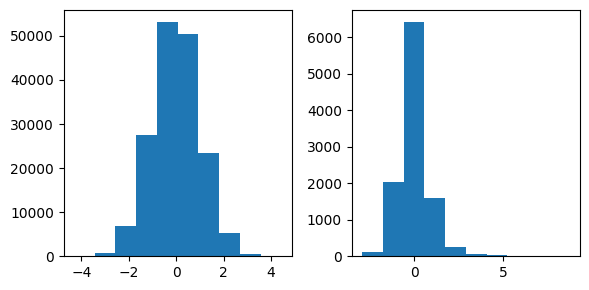

In [10]:
# from interaction import Interaction
from ridge_interaction import RidgeInteraction

machop = RidgeInteraction(
    slide_outs, 
    plm_embed=embeddings, 
    y=y,
    z_matrix=z_matrix,
    interacts_only=False,
    model='LR',
    ridge_thresh=0.0
)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].hist(machop.plm_embedding.flatten())
axs[1].hist(machop.z_matrix.flatten())
plt.tight_layout()

In [ ]:
fdr = 0.2
thresh = 0.5

machop.get_sig_interactions(fdr=fdr, n_iters=5, thresh=thresh)

Computing sig interactions using ORIGINAL interactions


In [ ]:
from plotting import show_interactions
show_interactions(machop, save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_betas_fdr{fdr}_thresh{thresh}_randPLM.png')

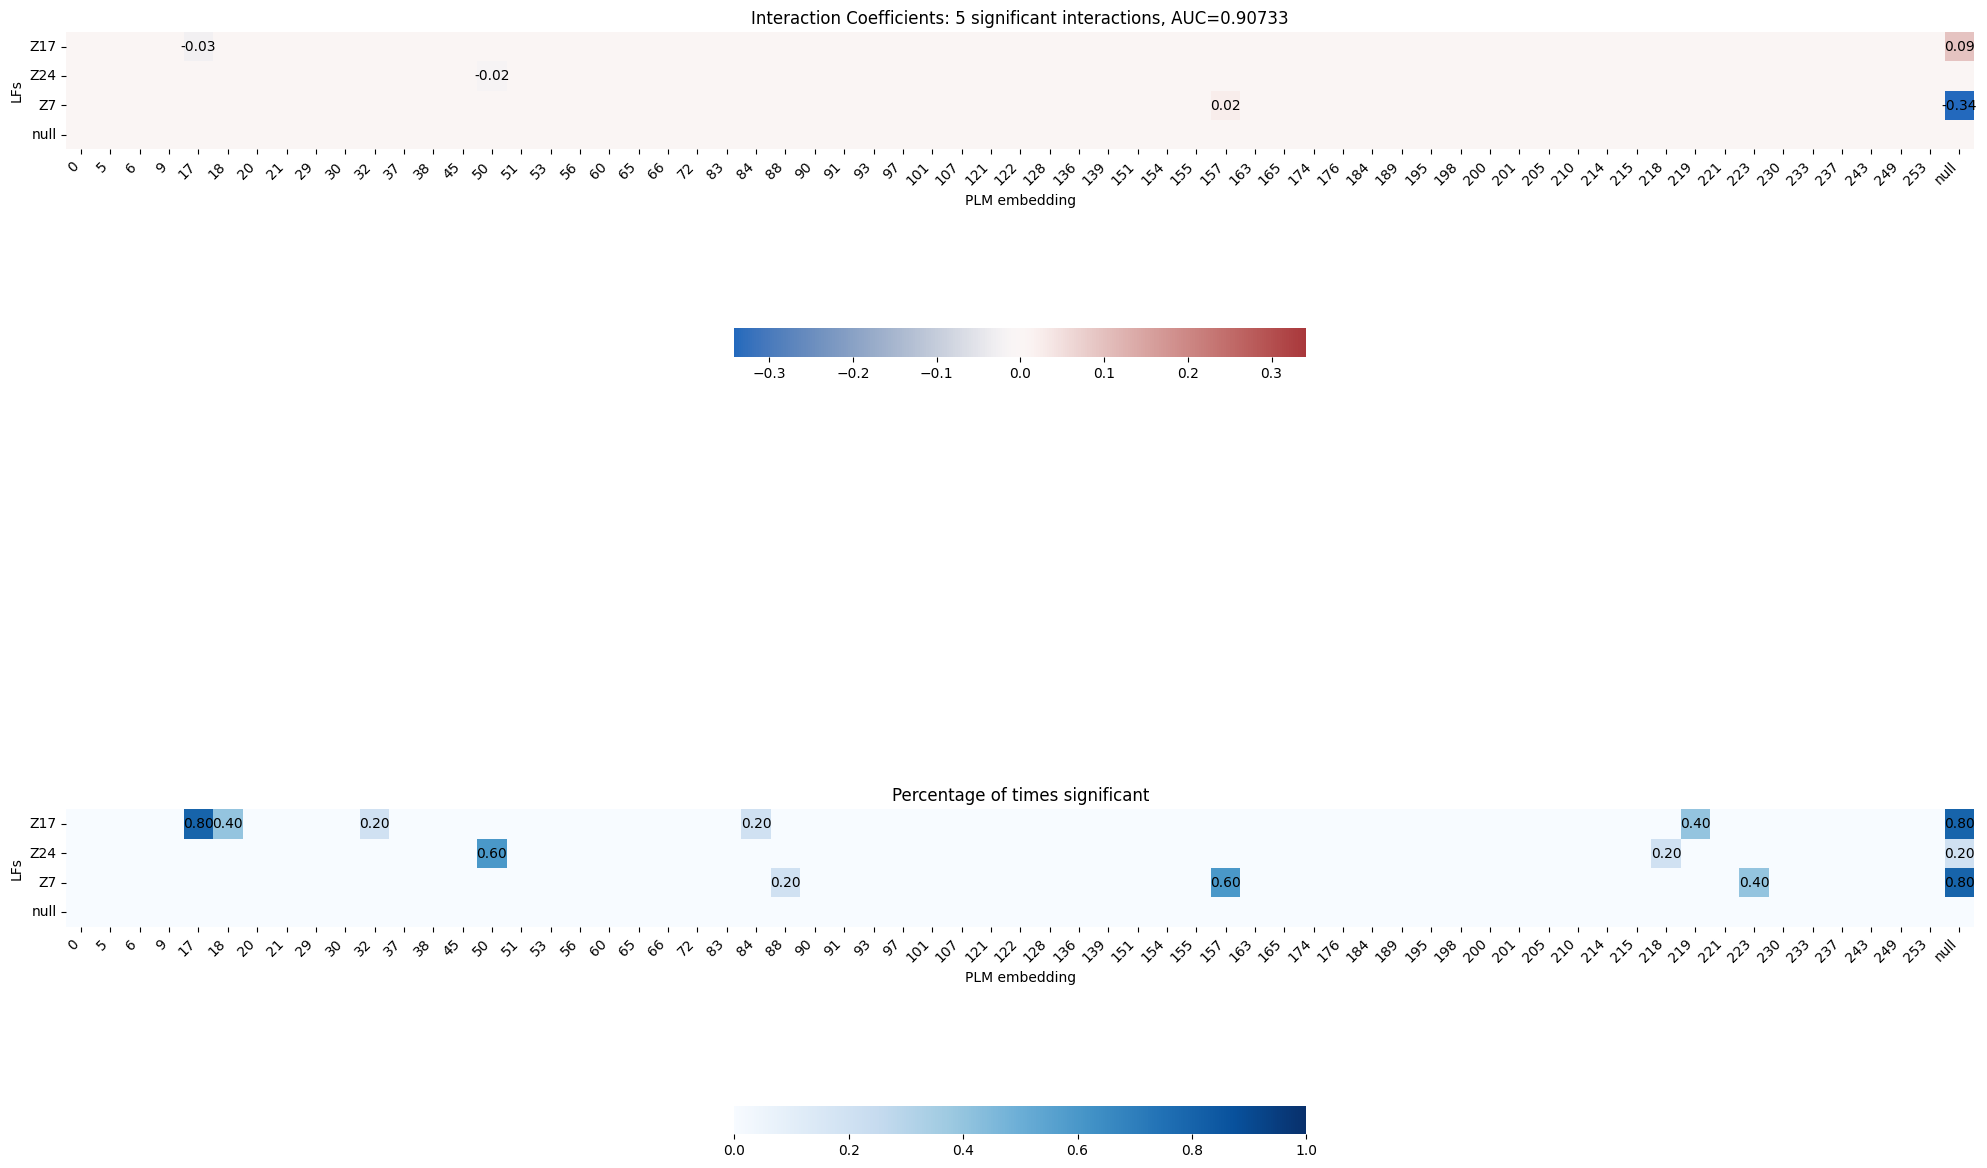

In [62]:
from plotting import show_interactions
show_interactions(machop, save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_betas_fdr{fdr}_thresh{thresh}.png')

In [63]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(2627, 5)

In [64]:
thresh = machop.params['thresh']
fdr = machop.params['fdr']
n_iters = machop.params['n_iters']

np.save(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_joint_embed_fdr{fdr}_iters{n_iters}_thresh_{thresh}.npy', joint_embed)

In [65]:
full_embed = np.hstack([machop.z_matrix, machop.plm_embedding])
full_embed.shape

(2627, 260)

In [66]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

model = Lasso(alpha=0.02)

In [67]:
estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)
auc1 = estimator.evaluate(full_embed, y)
auc2 = estimator.evaluate(machop.z_matrix, y)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [68]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01


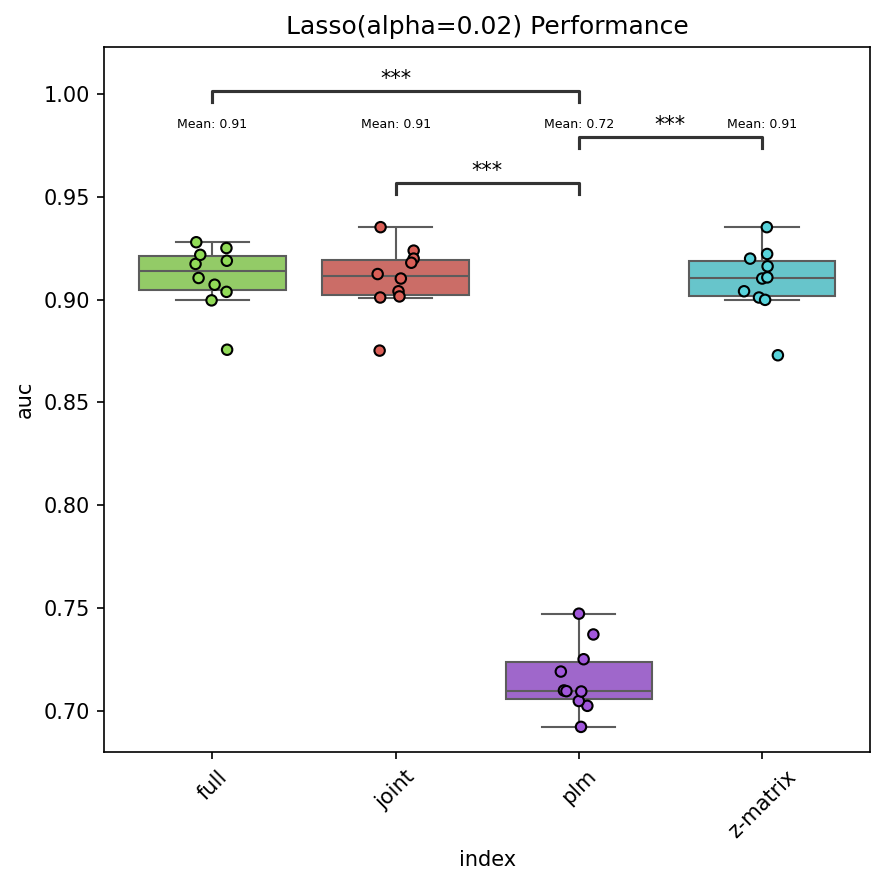

In [69]:
from plotting import show_performance
show_performance(model, df, 
                 save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_{model.__class__.__name__}_performance_fdr{fdr}_thresh{thresh}.png')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01


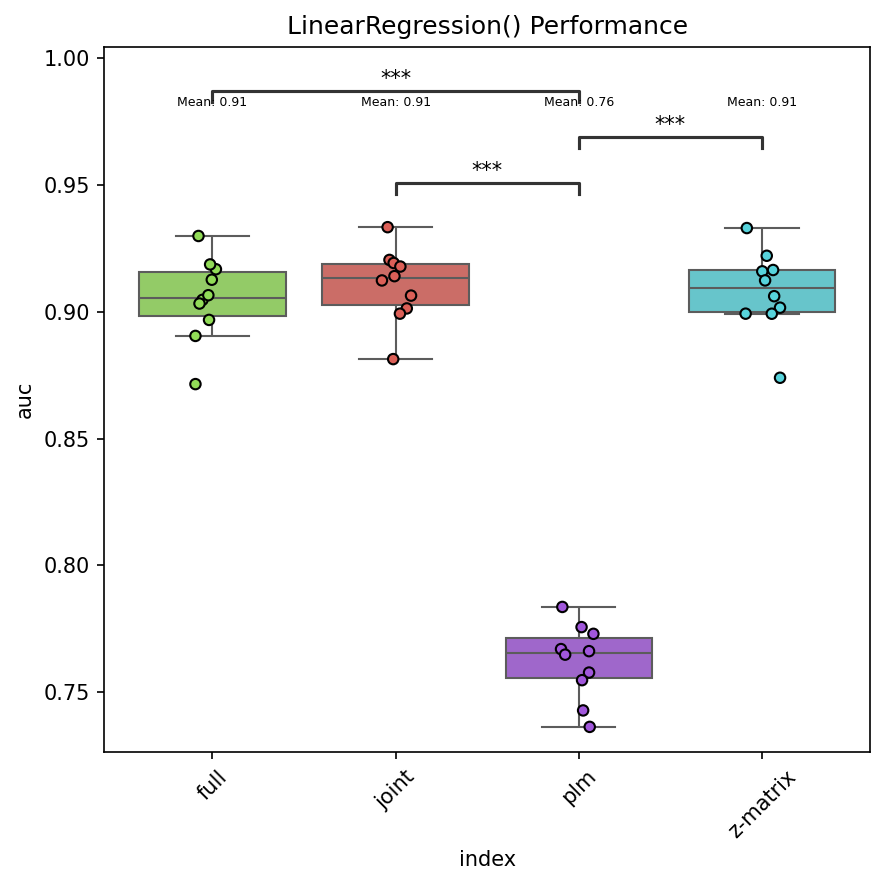

In [73]:
model = LinearRegression()
n_iters = 10

estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y, n_iters=n_iters)
auc1 = estimator.evaluate(full_embed, y, n_iters=n_iters)
auc2 = estimator.evaluate(machop.z_matrix, y, n_iters=n_iters)
auc3 = estimator.evaluate(machop.plm_embedding, y, n_iters=n_iters)

df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

show_performance(
    model, df, 
    save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_{model.__class__.__name__}_performance_fdr{fdr}_thresh{thresh}.png'
)

### Examine genes

In [ ]:
lf = 'Z98'

df= pd.read_csv(f'{slide_outs}/feature_list_{lf}.txt', sep='\t')   
red_genes = df[df['color'] == 'Red']['names'].values
blue_genes = df[df['color'] == 'Blue']['names'].values

print(red_genes)
print(blue_genes)

In [ ]:
red_text = '''Name: Immune Response Modulation and Cell Survival
LLM self-assessed confidence: Medium

1. **COL6A1** is a component of collagen VI, which is involved in the structural integrity of tissues and can influence immune cell migration and tissue repair processes.

2. **MCL1** is an anti-apoptotic member of the Bcl-2 family, playing a crucial role in cell survival, particularly in immune cells, by inhibiting apoptosis.

3. **CD7** is a transmembrane protein expressed on T cells and natural killer (NK) cells, involved in T-cell activation and interaction with other immune cells.

4. **NCR3** (also known as NKp30) is an activating receptor on NK cells, playing a role in the recognition and destruction of tumor cells and infected cells.

5. **CD99** is involved in leukocyte migration and T-cell adhesion, contributing to immune surveillance and response.

6. **DUSP2** is a dual-specificity phosphatase that negatively regulates MAPK signaling pathways, modulating immune responses and inflammation.

7. **LYAR** is a nucleolar protein involved in cell proliferation and may influence immune cell development and function.

8. **KLRD1** (CD94) is part of the receptor complex on NK cells that recognizes HLA-E molecules, modulating NK cell activity and immune response.

9. **IFITM2** is part of the interferon-induced transmembrane protein family, contributing to antiviral defense by inhibiting viral entry into host cells.

10. **S100A4** is involved in cell motility and metastasis, and can modulate immune responses and inflammation.

11. **IL2RB** is a component of the interleukin-2 receptor, crucial for T-cell proliferation and survival, playing a significant role in immune regulation.

12. **IL32** is a cytokine that can induce the production of other cytokines, such as TNF-alpha and IL-6, and is involved in inflammatory responses.

The proteins in this system are primarily involved in modulating immune responses and ensuring cell survival, particularly within the context of immune cell function. They interact to regulate immune cell activation, proliferation, and apoptosis, contributing to both innate and adaptive immune responses.

'''

blue_text = '''
Name: Protein modification and cellular signaling
LLM self-assessed confidence: Medium

1. **P3H1 (Prolyl 3-hydroxylase 1)** is involved in the post-translational modification of collagen, specifically hydroxylation of proline residues, which is crucial for collagen stability and function. This modification is essential for proper collagen folding and assembly, impacting extracellular matrix integrity.

2. **BCAS3 (Breast Carcinoma Amplified Sequence 3)** is implicated in angiogenesis and cellular migration. It interacts with cytoskeletal components and signaling pathways, influencing cell shape and movement, which are vital for vascular development and repair processes.

3. **STYK1 (Serine/Threonine/Tyrosine Kinase 1)** is a non-receptor kinase involved in signal transduction pathways. It plays a role in cell proliferation and survival, often associated with oncogenic processes. Its kinase activity can modulate various downstream signaling cascades.

4. **KLHDC1 (Kelch Domain Containing 1)** is less characterized but is thought to be involved in protein-protein interactions and may play a role in ubiquitination processes, impacting protein degradation and turnover.

5. **FGL2 (Fibrinogen-like 2)** functions in immune regulation and coagulation. It can act as a prothrombinase, contributing to fibrin formation and immune responses, particularly in inflammatory and thrombotic conditions.

6. **SELENOO (Selenoprotein O)** is involved in redox homeostasis and mitochondrial function. It participates in antioxidant defense mechanisms and may influence cellular stress responses through its selenoprotein activity.

7. **RHBDF2 (Rhomboid 5 Homolog 2)** is involved in the regulation of epidermal growth factor receptor (EGFR) signaling. It modulates the release of growth factors, impacting cell proliferation and differentiation.

8. **RMRP (RNA Component of Mitochondrial RNA Processing Endoribonuclease)** is a non-coding RNA involved in mitochondrial RNA processing and ribonucleoprotein complex formation, influencing mitochondrial function and cellular energy metabolism.

The proteins in this system are primarily involved in processes related to protein modification, cellular signaling, and structural integrity. They contribute to various cellular functions, including post-translational modifications, signal transduction, and cellular stress responses, which are crucial for maintaining cellular homeostasis and responding to environmental changes.

'''

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

red_words = Counter([word.strip('.,*()').lower() for word in red_text.split()])
blue_words = Counter([word.strip('.,*()').lower() for word in blue_text.split()])

combined_words = red_words + blue_words
ignore_words = [
    'the', 'and', 'is', 'of', 'or', 'in', 'to', 'a', 'for', 'on', 'that', 'this',
    'as', 'with', 'by', 'an', 'which', 'system', 'playing', 'cell', 'cells', 'related',
    'protein', 'proteins', 'involved', 'crucial', 'responses', 'medium', 'they', 'such'
    'essential', 'its', 'confidence:', 'facilitating', 'influence', 'also', 'these',
    'role', 'can', 'may', 'cellular',  'during', 'processes', 'function', 'self-assessed',
    'contributing', 'llm', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
    'other', 'are', 'indirectly', 'mrna', 'through', 'such', 'name:', 'help', 'not', 'roles',
    'however', 'important', 'prevents', 'gene', 'response', 'part', 'primarily', 'influence',
    'have', 'expressed', 'self-assessed', 'mechanisms', 'while', 'natural', 'critical', 
    'including', 'component', 'known', 'facilitates', 'less', 'well-characterized', 'context',
    'various', 'overall', 'contribute', 'functions', 'their', 'influencing', 'expression',
    'particularly', 'plays'
]
combined_words = {word: count for word, count in combined_words.items() if word.lower() not in ignore_words}

def color_func(word, **kwargs):
    if word in red_words and word in blue_words:
        return "purple"
    elif word in red_words:
        return "red"
    elif word in blue_words:
        return "blue"
    return "black"

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_words)
wordcloud.recolor(color_func=color_func)

plt.figure(figsize=(10, 5), dpi=500)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'{lf} word cloud')
plt.show()

### Compare CONGA

In [ ]:
stop!

In [ ]:
fdr = 0.2
thresh = 0.8
n_iters = 20

# Use joint_embedding
joint_embed = np.load(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_joint_embed_fdr{fdr}_iters{n_iters}_thresh_{thresh}.npy')
joint_embed.shape

In [ ]:
adata.obs['clusters_gex'] = adata.obs['clusters_gex'].astype('category')
adata.obs['clusters_tcr'] = adata.obs['clusters_tcr'].astype('category')
adata.obs['conga_scores_significant'] = np.where(adata.obs['conga_scores'] <= 1, 1, 0)

adata.obsm['X_umap'] = adata.obsm['X_umap_gex']
sc.pl.umap(adata, color=['conga_scores_significant', 'clusters_gex', 'clusters_tcr'])

In [ ]:
adata.obsm['X_umap'] = adata.obsm['X_umap_tcr']
sc.pl.umap(adata, color=['conga_scores_significant', 'clusters_gex', 'clusters_tcr'])

In [ ]:
embed_data = sc.AnnData(joint_embed)
embed_data.obs['y'] = y
embed_data.obs['y'] = embed_data.obs['y'].astype('category')

embed_data.obs['conga_gex_clusters'] = adata.obs['clusters_gex'].values
embed_data.obs['conga_gex_clusters'] = embed_data.obs['conga_gex_clusters'].astype('category')
embed_data.obs['conga_scores'] = adata.obs['conga_scores'].values
embed_data.obs['conga_scores_significant'] = adata.obs['conga_scores_significant'].values

sc.pp.neighbors(embed_data)
sc.tl.pca(embed_data)
sc.tl.umap(embed_data)
sc.tl.leiden(embed_data)

In [ ]:
from tqdm import tqdm
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

performance = {}
model = LinearRegression()
estimator = Estimator(model=model)


for cluster in tqdm(embed_data.obs['conga_gex_clusters'].unique()):

    cluster_data = embed_data[embed_data.obs['conga_gex_clusters'] != cluster]

    y_cluster = cluster_data.obs['y'].values
    X_cluster = cluster_data.X

    auc = estimator.evaluate(X_cluster, y_cluster, n_iters=30)
    performance[cluster] = auc

In [ ]:
aucs = pd.DataFrame(performance).T
aucs.rename(columns={i: f'iter_{i}' for i in range(len(aucs.columns))}, inplace=True)
aucs['mean'] = aucs.mean(axis=1, skipna=True)
aucs['std'] = aucs.std(axis=1, skipna=True)
aucs.sort_values('mean')

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

# aucs.drop(columns=['mean', 'std'], inplace=True)
df = aucs.melt(id_vars='index', var_name='iter', value_name='auc')

fig, ax = plt.subplots(figsize=(10,4), dpi=150)
order = np.unique(df['index'])

sns.boxplot(data=df, x='index', y='auc', hue='index', palette='hls', ax=ax, legend=False, showfliers=False, order=order)
sns.stripplot(data=df, x='index', y='auc', hue='index', ax=ax, palette='hls', legend=False, linewidth=1, edgecolor='black', jitter=True)
ax.set_xlabel('cluster')
plt.title('Linear Regression with Joint Embedding when CONGA Cluster is Omitted')


In [ ]:
sc.pl.pca(embed_data, color=['y', 'leiden', 'conga_gex_clusters', 'conga_scores_significant'])
sc.pl.umap(embed_data, color=['y', 'leiden', 'conga_gex_clusters', 'conga_scores_significant'])

In [ ]:
import matplotlib.pyplot as plt

n_plots = (joint_embed.shape[1] + 1) // 2
n_rows = (n_plots + 2 - 1) // 2 

fig, axs = plt.subplots(2, n_rows, figsize=(20, n_rows * 4)) 
axs = axs.flatten()

for i in range(0, joint_embed.shape[1], 2):
    dim1 = joint_embed[:, i]
    dim2 = joint_embed[:, i+1] if i+1 < joint_embed.shape[1] else joint_embed[:, i-1] 
    
    axs[i//2].scatter(dim1, dim2, c=y, alpha=0.5, cmap='coolwarm', s=2)
    axs[i//2].set_xlabel(f'joint embed {i}')
    axs[i//2].set_ylabel(f'joint embed {i+1}' if i+1 < joint_embed.shape[1] else f'joint embed {i-1}')

plt.suptitle('Separation of classes using joint embedding from Daniel\'s model', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()
